In [1]:
TRAIN = '/kaggle/input/animals10/raw-img'

We want to use image embeddings from ResNeXt for both EDA and classification, so let's add code to get those.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 159MB/s]


Let's load up our image embeddings and thumbnails. We have limited resources, so let's take a sample.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if input_file.endswith('.jpg') and index < 500]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 0 rows of cavallo  in 0:00:00.185993
encoded 99 rows of pecora  in 0:00:14.254589
encoded 111 rows of elefante  in 0:00:15.453966
encoded 131 rows of gatto  in 0:00:24.376845
encoded 0 rows of scoiattolo  in 0:00:00.168521
encoded 0 rows of gallina  in 0:00:00.042267
encoded 27 rows of ragno  in 0:00:03.801044
encoded 0 rows of mucca  in 0:00:00.149822
encoded 0 rows of cane  in 0:00:00.192529
encoded 101 rows of farfalla  in 0:00:14.068749
done in 0:01:12.748091


Because we're not very careful about getting our sample we have unbalanced classes; how unbalanced are they?

In [4]:
train_df['tag'].value_counts(normalize=True).to_frame().sort_values(by='proportion').T

tag            ragno    pecora  farfalla  elefante     gatto
proportion  0.057569  0.211087  0.215352  0.236674  0.279318

Next let's use TSNE to get x/y coordinates based on our image embeddings.

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 469 samples in 0.003s...
[t-SNE] Computed neighbors for 469 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 469 / 469
[t-SNE] Mean sigma: 3.243462
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.209743
[t-SNE] KL divergence after 1000 iterations: 0.525511


Now we're ready to plot.

In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: animals', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? For the most part TSNE separates our images into distinct clusters, with some difficult cases. And it separates dog breeds into distinct subclusters, and to a lesser degree it separates cats. But on balance we have good reason to be optimistic about our model accuracy. Let's build a model and find out.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.2, random_state=2024, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=10000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 49 iterations
accuracy: 1.0000
f1: 1.0000
              precision    recall  f1-score   support

    elefante       1.00      1.00      1.00        22
    farfalla       1.00      1.00      1.00        20
       gatto       1.00      1.00      1.00        26
      pecora       1.00      1.00      1.00        20
       ragno       1.00      1.00      1.00         6

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94



Our f1 looks nice, althought it varies a little from class to class. Let's look at our confusion matrix.

<Axes: >

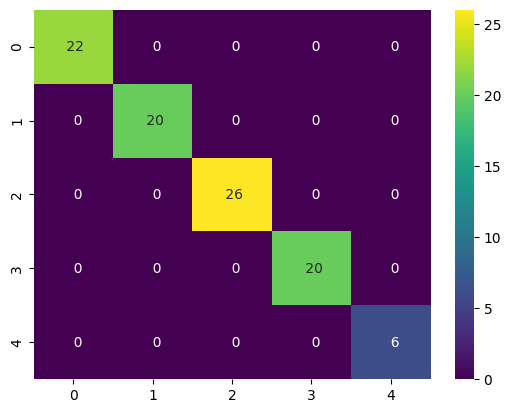

In [8]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

heatmap(annot=True, data=pd.DataFrame(data=confusion_matrix(y_true=y_test, y_pred=logreg.predict(X=X_test), ),), cmap='viridis', fmt='3')

Our confusion matrix looks about like we might expect based on our scatter plot above. We have some difficult cases, but no systemic issues. Let's look at our model probabilities.

<Axes: xlabel='x', ylabel='y'>

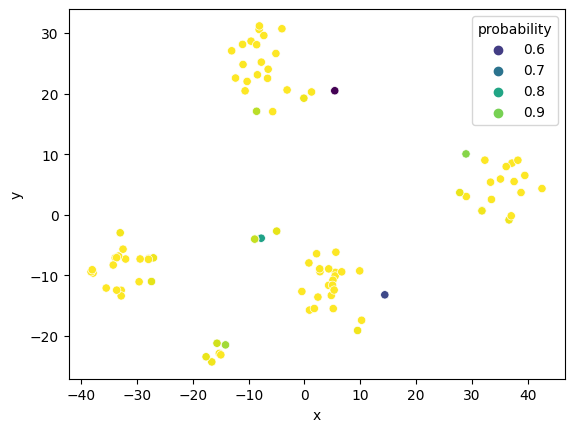

In [9]:
from seaborn import scatterplot

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)
scatterplot(data=plot_df, x='x', y='y', hue='probability', palette='viridis')

Our model probabilities are generally really high, except for some low values where we have difficult cases.